# Example 1: 2-D fault network extraction from a numerical model
This example describes how to extract a 2-D fault network from a numerical model simulating continental rifting. This example is based on the study of Naliboff et al. (2020).

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/example-1/example-1.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!git clone https://github.com/thilowrona/fault_analysis_toolbox

Cloning into 'fault_analysis_toolbox'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 1810 (delta 21), reused 0 (delta 0), pack-reused 1755
Receiving objects: 100% (1810/1810), 329.61 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Checking out files: 100% (1390/1390), done.


In [2]:
!pip3 install vtk
!pip3 install git+https://github.com/ulikoehler/cv_algorithms.git

     |████████████████████████████████| 103.4MB 48kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-req-build-pbj0wezc
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-req-build-pbj0wezc
  Created wheel for cv-algorithms: filename=cv_algorithms-1.0.0-cp36-cp36m-linux_x86_64.whl size=43516 sha256=7c4583f26e24db16be125fffa23cd021c2419d3f47f71d893b860f13c3188bf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbeftk4e/wheels/0b/45/f6/dfa0d535f50a0148a4c7d6912942fdb7a6445d7196a2591cbe
Successfully built cv-algorithms


Now we can load the python packages:

In [3]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

and the functions from the fault analysis toolbox that we want to use:

In [4]:
import sys
sys.path.append('/content/fault_analysis_toolbox/code/')

from image_processing import guo_hall
from edits import array_to_points, label_components
from plots import plot_components

## Fault extraction

First, we load our data - a strain rate map extracted just below the surface of the model:

In [5]:
strain_rate = np.load('/content/fault_analysis_toolbox/examples/example-1/NearSurfaceIsotherm_335K_strain_rate.npy')

Now we can plot it to visualize the faults in the model

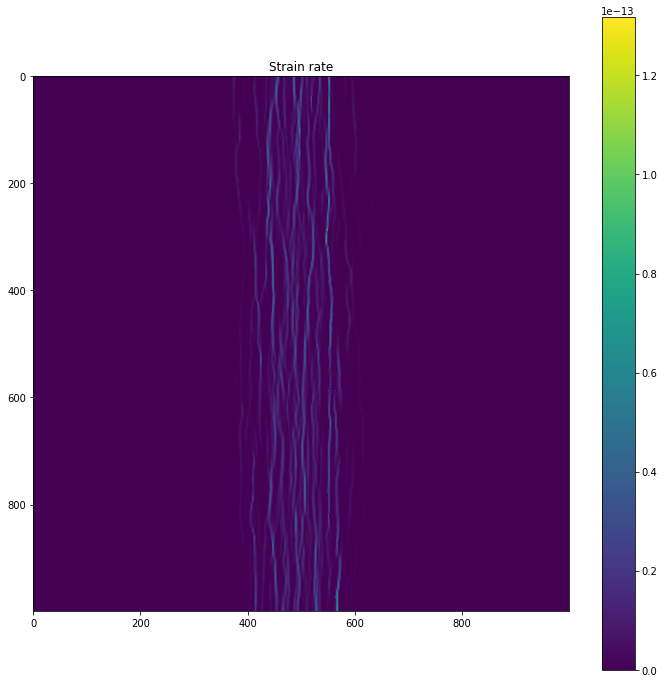

In [6]:
plt.figure(figsize=(12,12))
plt.title('Strain rate')
plt.imshow(strain_rate, vmin=0)
plt.colorbar()
plt.show()

Next we want to separate the faults from the background using a threshold:

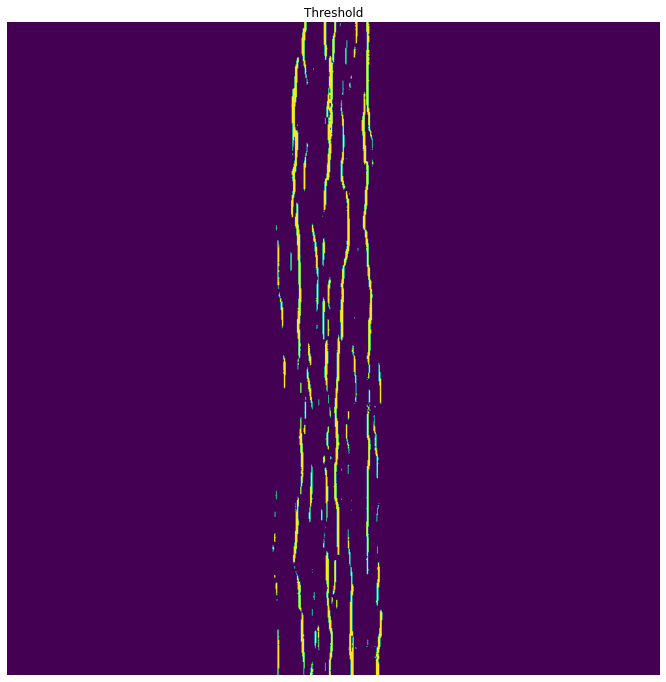

In [7]:
threshold = np.where(strain_rate > 1.5e-14, 1, 0).astype(np.uint8)

plt.figure(figsize=(12,12))
plt.title('Threshold')
plt.imshow(threshold)
plt.axis('off')
plt.show()

Then we reduce the areas above the threshold to lines using a skeletonize algorithm:

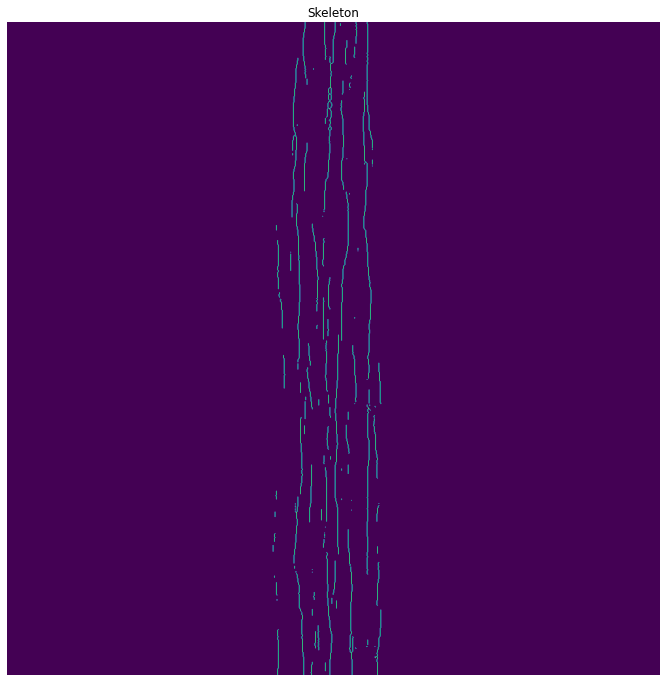

In [8]:
skeleton = guo_hall(threshold)

plt.figure(figsize=(12,12))
plt.title('Skeleton')
plt.imshow(skeleton)
plt.axis('off')
plt.show()

Now we can convert these lines to points:

In [9]:
points = array_to_points(skeleton)

and build our graph, first by adding the points as nodes:

In [10]:
G = nx.Graph()

for node, point in enumerate(points):
    G.add_node(node)
    G.nodes[node]['pos'] = point

Next we calculate the distance between the nodes and connect the ones close to each other (<1.5 pixels away)

In [11]:
dm = distance_matrix(points, points) 

print(str(points.shape[0]) + ' Points')
for n in range(points.shape[0]):
    stdout.write("\r%d" % n)
    stdout.flush()
    for m in range(points.shape[0]):
        if dm[n,m]<1.5:
            G.add_edge(n,m)

5665 Points
5664

Now we can label the nodes that are connect to one another as components:

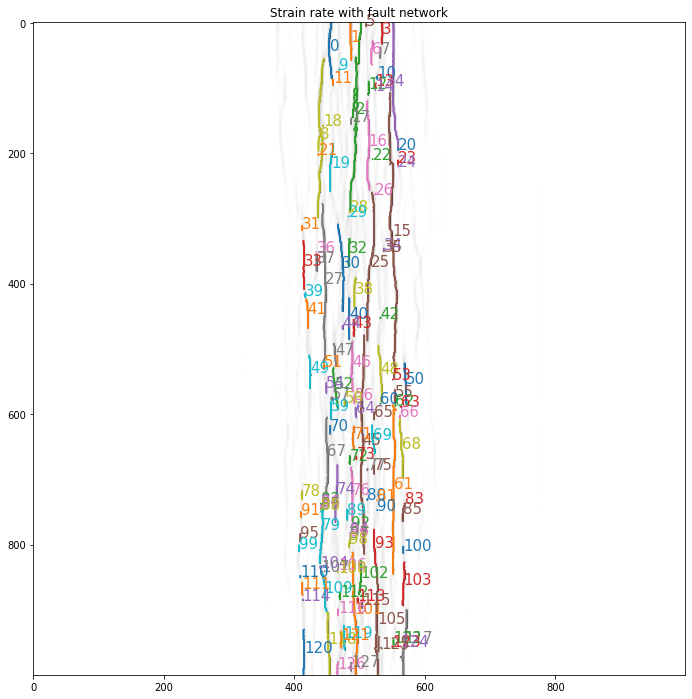

In [15]:
G = label_components(G)

fig, axs = plt.subplots(1, 1, figsize=(12,12))
axs.imshow(strain_rate, 'gray_r', vmin=0)
plot_components(G, axs, label=True)
plt.title('Strain rate with fault network')
plt.show()

When we zoom in, we can see the nodes colored by their component and the edges connecting them:

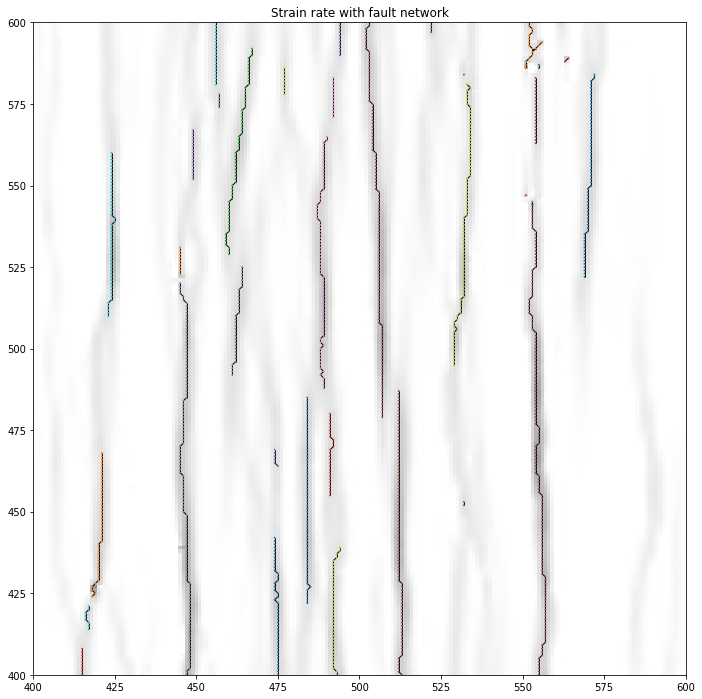

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(12,12))
axs.imshow(strain_rate, 'gray_r', vmin=0)
plot_components(G, axs, label=False)
axs.set_xlim([400, 600])
axs.set_ylim([400, 600])
plt.title('Strain rate with fault network')
plt.show()